In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math

%config InlineBackend.figure_format = 'retina'

# Impemenant Loss Based on Virtual Reserves

This is based on constant product market maker, i.e. k = x * y, which is used by Uniswap v1 and v2.

In [3]:
# Example: https://www.youtube.com/watch?v=8XJ1MSTEuU0
def calPrice (eth_price):
  # Initial Stage: DAI-ETH 50/50
  dai_holdings0 = 10000
  eth_holdings0 = 20
  dai_price0 = 1
  eth_price0 = 500
  k = dai_holdings0 * eth_holdings0 # 200000

  holdings_value0 = dai_holdings0 * dai_price0 + eth_holdings0 * eth_price0

  # Now eth_price = eth_price / dai_price = dai_holdings / eth_holdings

  dai_holdings = math.sqrt(k * eth_price)
  eth_holdings = math.sqrt(k / eth_price)
  print("dai_holdings = ", dai_holdings, ", eth_holdings = ", eth_holdings)

  eth_out = eth_holdings0 - eth_holdings
  dai_in = dai_holdings - dai_holdings0
  eth_price_arbitrageur = dai_in / eth_out
  print("Arbitrageur buys: ", eth_out, "eth, using ", dai_in, "dai, at a price of", eth_price_arbitrageur)

  # After arbitrage
  holdings_value = dai_holdings * dai_price0 + eth_holdings * eth_price
  # If holding the original funds supplied, Without providing liquidity
  holdings_value_no_LP = dai_holdings0 * dai_price0 + eth_holdings0 * eth_price

  impermanent_loss = holdings_value_no_LP - holdings_value
  print("Before arbitrage, holdings value is", holdings_value0)
  print("After arbitrage, holdings value is", holdings_value)
  print("If liquidity provider holds the asset, holdings value is", holdings_value_no_LP)
  print("IL is", impermanent_loss)

calPrice(550)

dai_holdings =  10488.088481701516 , eth_holdings =  19.069251784911845
Arbitrageur buys:  0.9307482150881548 eth, using  488.0884817015158 dai, at a price of 524.4044240850754
Before arbitrage, holdings value is 20000
After arbitrage, holdings value is 20976.17696340303
If liquidity provider holds the asset, holdings value is 21000
IL is 23.82303659696845


In [4]:
# IL based on virtual reserves (constant product market maker, k = x * y, used by Uniswap V1 and V2)
def getIL (eth_price_ratio):
  # Initial Stage: DAI-ETH 50/50
  dai_holdings0 = 10000
  eth_holdings0 = 20
  dai_price0 = 1
  eth_price0 = 500
  k = dai_holdings0 * eth_holdings0 # 200000
  # holdings_value0 = dai_holdings0 * dai_price0 + eth_holdings0 * eth_price0
  eth_price = eth_price_ratio * eth_price0     # = dai_holdings / eth_holdings
  dai_holdings = math.sqrt(k * eth_price)
  eth_holdings = math.sqrt(k / eth_price)
  holdings_value = dai_holdings * dai_price0 + eth_holdings * eth_price
  holdings_value_no_LP = dai_holdings0 * dai_price0 + eth_holdings0 * eth_price

  impermanent_loss = (holdings_value_no_LP - holdings_value) / holdings_value_no_LP

  return impermanent_loss

print(getIL(1.1))

0.0011344303141413547


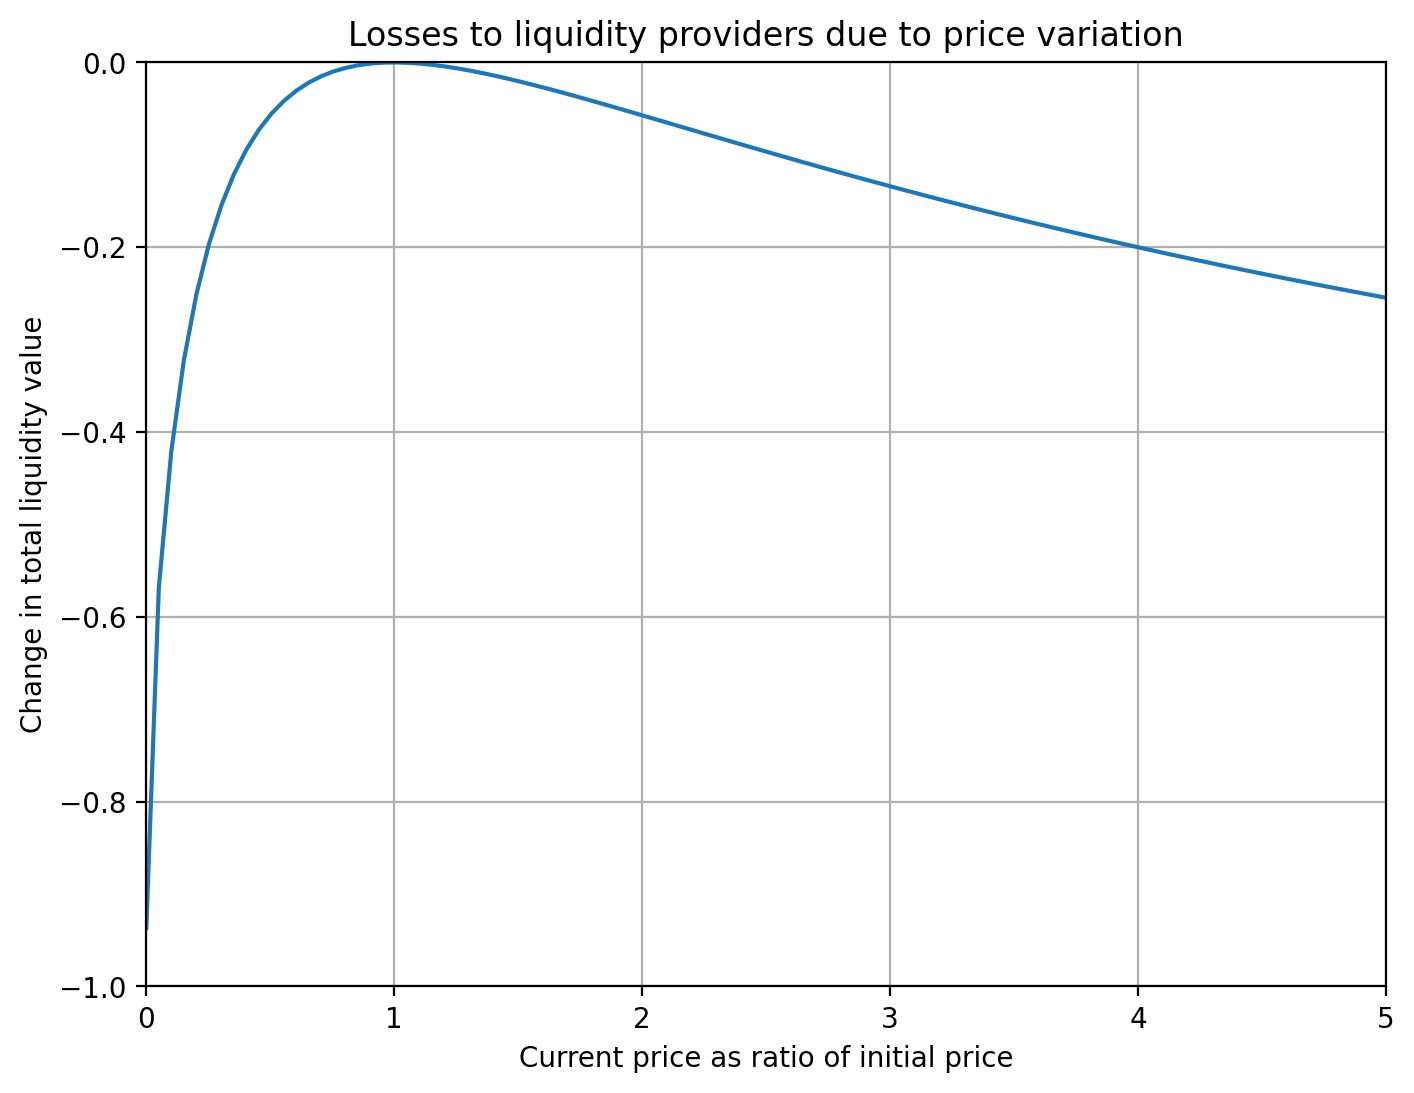

In [6]:
Current_Price = np.linspace(0.001, 5, 100)
IL = [-getIL(x) for x in Current_Price]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(Current_Price, IL)
ax.set_xlabel("Current price as ratio of initial price")
ax.set_ylabel("Change in total liquidity value")
ax.set_title("Losses to liquidity providers due to price variation")
plt.xlim([0, 5])
plt.ylim([-1, 0])
plt.grid(True)

plt.show()

# Impemenant Loss Based on Concentrated Liquidity
This is based on a position ranged at [pa, pb], i.e. (x + L/sqrt(pb)) * (y + L*sqrt(pa)) = L^2, which is used by Uniswap v3.

In [8]:
# functions from here: https://github.com/atiselsts/uniswap-v3-liquidity-math/blob/master/uniswap-v3-liquidity-math.py
def get_liquidity_0(x, sa, sb):
    return x * sa * sb / (sb - sa)

def get_liquidity_1(y, sa, sb):
    return y / (sb - sa)

def get_liquidity(x, y, sp, sa, sb):
    if sp <= sa:
        liquidity = get_liquidity_0(x, sa, sb)
    elif sp < sb:
        liquidity0 = get_liquidity_0(x, sp, sb)
        liquidity1 = get_liquidity_1(y, sa, sp)
        liquidity = min(liquidity0, liquidity1)
    else:
        liquidity = get_liquidity_1(y, sa, sb)
    return liquidity

def calculate_x(L, sp, sa, sb):
    sp = max(min(sp, sb), sa)     # if the price is outside the range, use the range endpoints instead
    return L * (sb - sp) / (sp * sb)

def calculate_y(L, sp, sa, sb):
    sp = max(min(sp, sb), sa)     # if the price is outside the range, use the range endpoints instead
    return L * (sp - sa)

def calculateAmounts(p, a, b, x, y, P1):
    sp = p ** 0.5
    sa = a ** 0.5
    sb = b ** 0.5
    L = get_liquidity(x, y, sp, sa, sb)

    sp1 = P1 ** 0.5

    sp = max(min(sp, sb), sa)
    sp1 = max(min(sp1, sb), sa)

    delta_p = sp1 - sp
    delta_inv_p = 1/sp1 - 1/sp
    delta_x = delta_inv_p * L
    delta_y = delta_p * L
    x1 = x + delta_x
    y1 = y + delta_y

    return x1, y1

def find_max_x(p, a, b, vMax):
    sp = p ** 0.5
    sa = a ** 0.5
    sb = b ** 0.5
    x = 0.001  # starting value for x
    step = 0.001
    while True:
        L = get_liquidity_0(x, sp, sb)
        y = calculate_y(L, sp, sa, sb)
        v = x*p + y
        if v >= vMax:
            break
        x += step
    return x - step

def find_max_x2(p, a, b, vMax): # KZ: find_max_x using brute force method, could cost a large gas fee. and find_max_x2 has the same solution, with less calculation cost
    sp = p ** 0.5
    sa = a ** 0.5
    sb = b ** 0.5
    x2 = vMax/((sp-sa)*sp*sb/(sb-sp)+p)
    return x2

x=find_max_x(1000, 800, 1200, 1000)
x2=find_max_x2(1000, 800, 1200, 1000)
print("X = {:.3f}".format(x))
print("X2 = {:.3f}".format(x2))

X = 0.452
X2 = 0.452


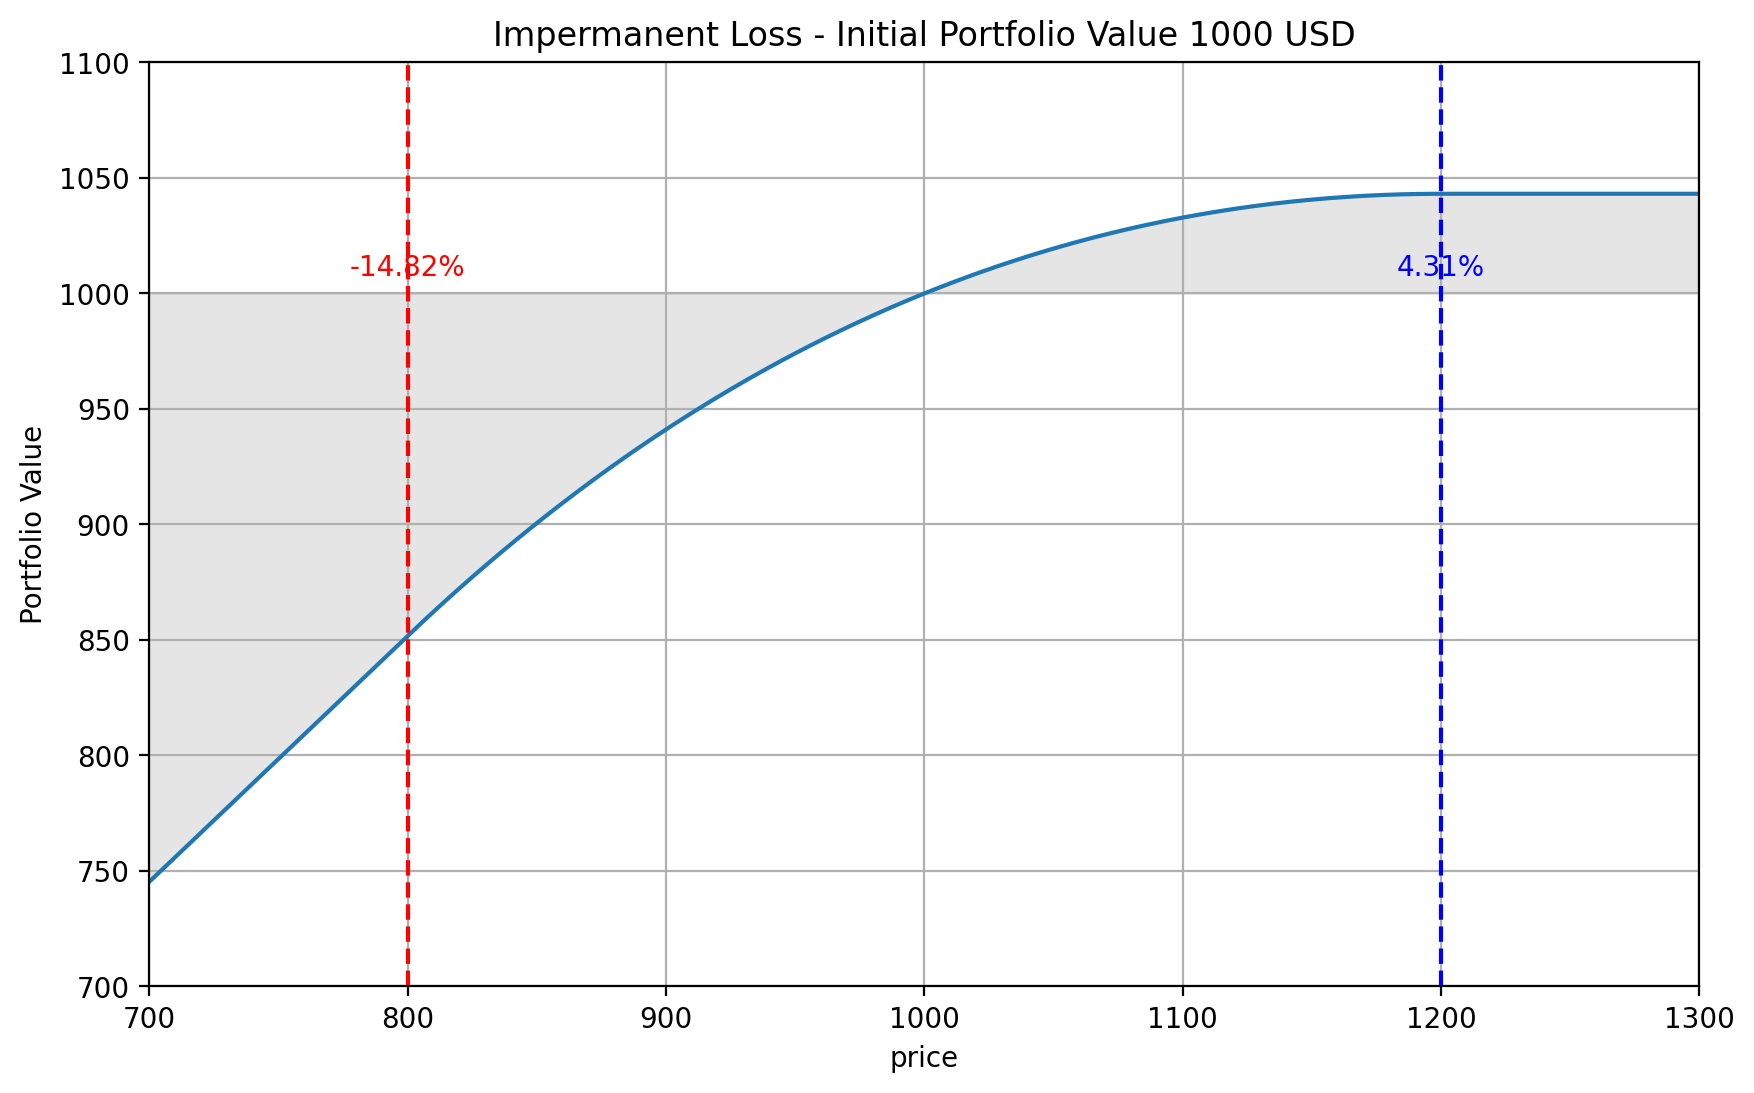

In [9]:
# Example from https://github.com/uniHedge/uniHedge-research/blob/main/hedgeV3_with_short.ipynb
p = 1000 # current price
a = p - (1000 * 0.2) # lower price 10% below current price
b = p + (1000 * 0.2) # upper price 10% above current price
short_price = 1000
maximumPortfolioValue = 1000  # initial value of the porfolio

## PLOT IL
x_1 = find_max_x(p, a, b, maximumPortfolioValue)
y_1 = maximumPortfolioValue - x_1 * p

# Create empty lists to store the values
P1_values = []
value_values = []

# Loop through the range of P1 from 500 to 1500
for P1 in range(500, 1501):
    x1, y1 = calculateAmounts(p, a, b, x_1, y_1, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula

    # Append the P1 and value to their respective lists
    P1_values.append(P1)
    value_values.append(value)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(P1_values, value_values, linestyle='-')
plt.title('Impermanent Loss - Initial Portfolio Value 1000 USD')
plt.xlabel('price')
plt.ylabel('Portfolio Value')
plt.grid(True)

# Calculate percentage changes at 'a' and 'b'
value_at_a = calculateAmounts(p, a, b, x_1, y_1, a)[0] * a + calculateAmounts(p, a, b, x_1, y_1, a)[1]
percent_change_a = ((value_at_a - maximumPortfolioValue) / maximumPortfolioValue) * 100

value_at_b = calculateAmounts(p, a, b, x_1, y_1, b)[0] * b + calculateAmounts(p, a, b, x_1, y_1, b)[1]
percent_change_b = ((value_at_b - maximumPortfolioValue) / maximumPortfolioValue) * 100

# Add vertical dotted lines for points 'a' and 'b'
plt.axvline(x=a, color='r', linestyle='--')
plt.axvline(x=b, color='b', linestyle='--')

# Shade the difference area
where_condition = [value != maximumPortfolioValue for value in value_values]
plt.fill_between(P1_values, value_values, maximumPortfolioValue, where=where_condition, interpolate=True, color='grey', alpha=0.2)

# Place the percent change on the sides of the chart
plt.text(a, maximumPortfolioValue + 5, f'{percent_change_a:.2f}%', color='r', ha='center', va='bottom')
plt.text(b, maximumPortfolioValue + 5, f'{percent_change_b:.2f}%', color='b', ha='center', va='bottom')

plt.xlim(a-100, b+100)
plt.ylim(700, 1100)

# Show the plot
plt.show()

In [14]:
# Using ETH price in the previous month
# https://coinmarketcap.com/currencies/ethereum/

df = pd.read_csv('ETH_1M_converted.csv')
print(df[['open', 'timestamp']])

           open         timestamp
0   1635.201096   9/16/2023 20:00
1   1623.081927   9/17/2023 20:00
2   1637.312047   9/18/2023 20:00
3   1643.495308   9/19/2023 20:00
4   1622.591776   9/20/2023 20:00
5   1584.002578   9/21/2023 20:00
6   1593.213108   9/22/2023 20:00
7   1593.825699   9/23/2023 20:00
8   1580.747472   9/24/2023 20:00
9   1588.023168   9/25/2023 20:00
10  1593.108255   9/26/2023 20:00
11  1597.672008   9/27/2023 20:00
12  1652.999878   9/28/2023 20:00
13  1667.834491   9/29/2023 20:00
14  1671.161528   9/30/2023 20:00
15  1732.984005   10/1/2023 20:00
16  1662.887206   10/2/2023 20:00
17  1656.735998   10/3/2023 20:00
18  1647.788198   10/4/2023 20:00
19  1611.365713   10/5/2023 20:00
20  1645.810875   10/6/2023 20:00
21  1634.657351   10/7/2023 20:00
22  1633.454852   10/8/2023 20:00
23  1580.112120   10/9/2023 20:00
24  1567.680760  10/10/2023 20:00
25  1566.356015  10/11/2023 20:00
26  1539.432832  10/12/2023 20:00
27  1552.263809  10/13/2023 20:00
28  1555.07609

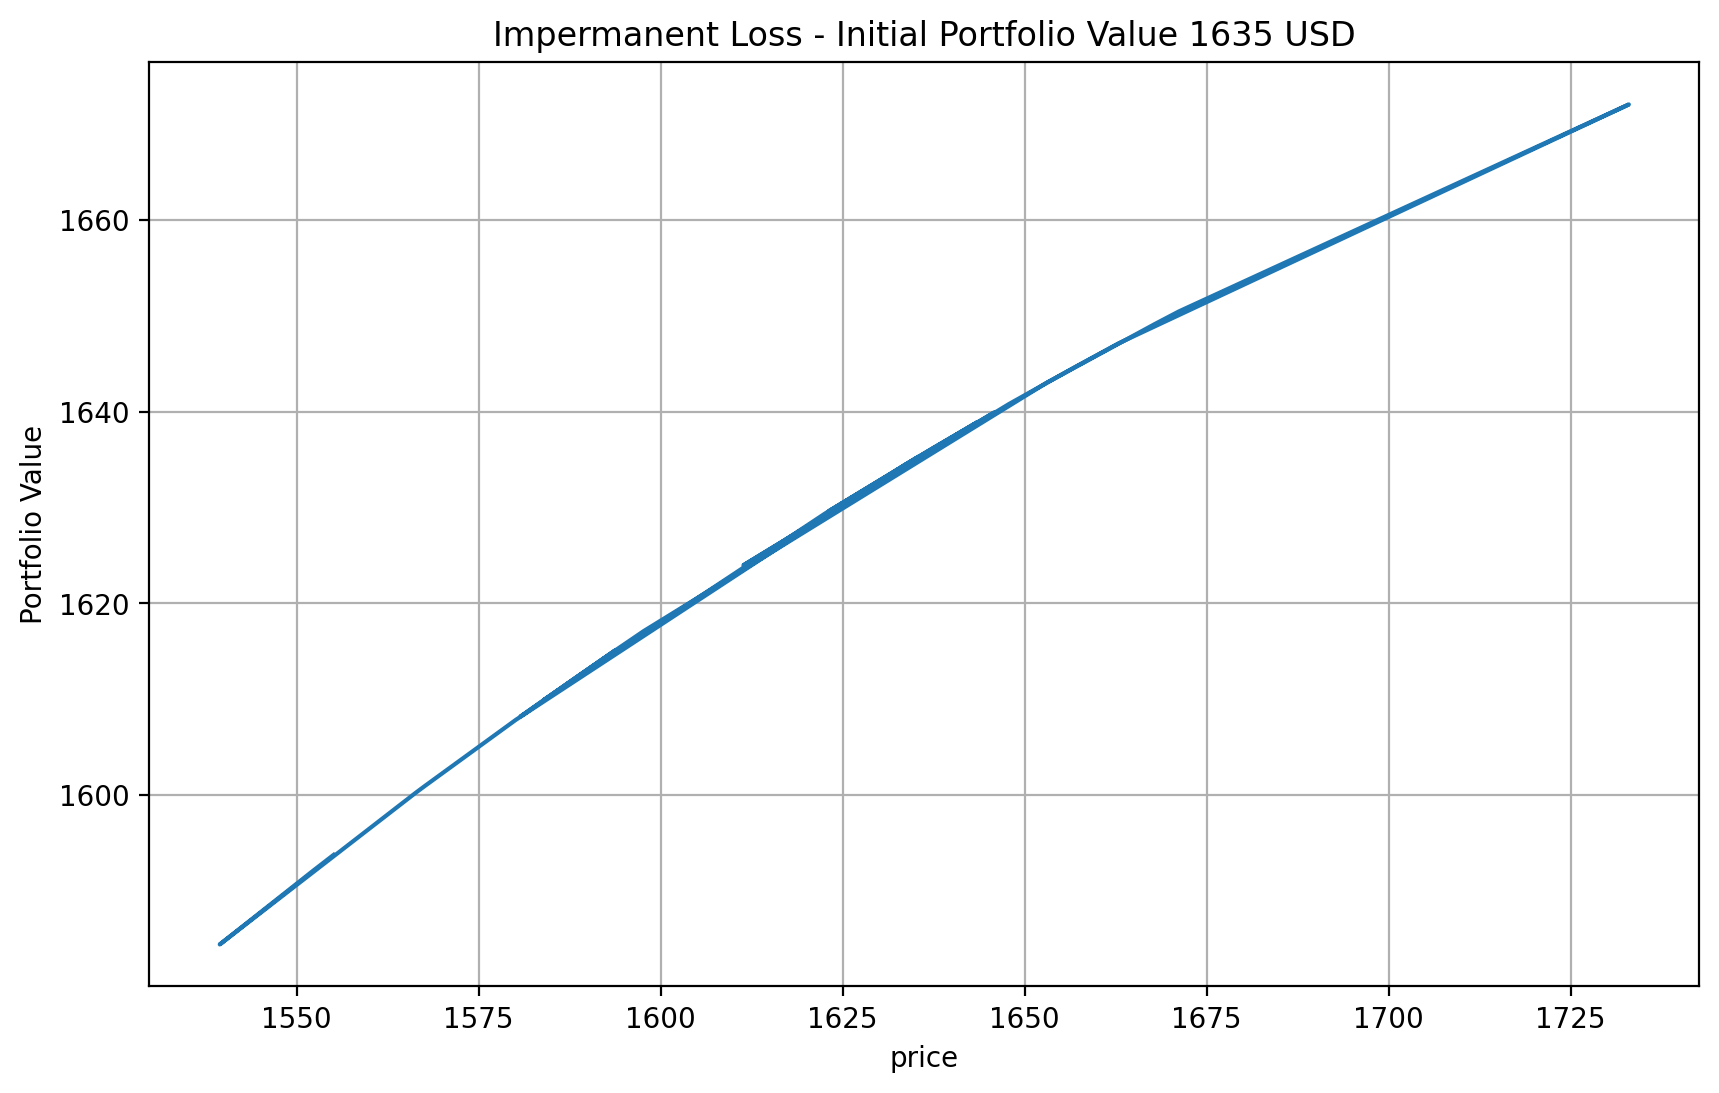

In [20]:

p0 = df['open'][0]

a = 0.8 * p0
b = 1.2 * p0
short_price = p0
maximumPortfolioValue = p0  # initial value of the porfolio

## PLOT IL
x_1 = find_max_x(p0, a, b, maximumPortfolioValue)
y_1 = maximumPortfolioValue - x_1 * p0

# Create empty lists to store the values
P1_values = []
value_values = []

# Loop through the range of P1 from 500 to 1500
for P1 in df['open']:
    x1, y1 = calculateAmounts(p0, a, b, x_1, y_1, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula

    # Append the P1 and value to their respective lists
    P1_values.append(P1)
    value_values.append(value)

x_1 = [find_max_x(p, a, b, maximumPortfolioValue) for p in df['open']]
y_1 = [maximumPortfolioValue - x * p0 for x in x_1]
values = [x * p + y for x, p, y in zip(x_1, df['open'], y_1)]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(P1_values, value_values, linestyle='-')
plt.title('Impermanent Loss - Initial Portfolio Value 1635 USD')
plt.xlabel('price')
plt.ylabel('Portfolio Value')
plt.grid(True)

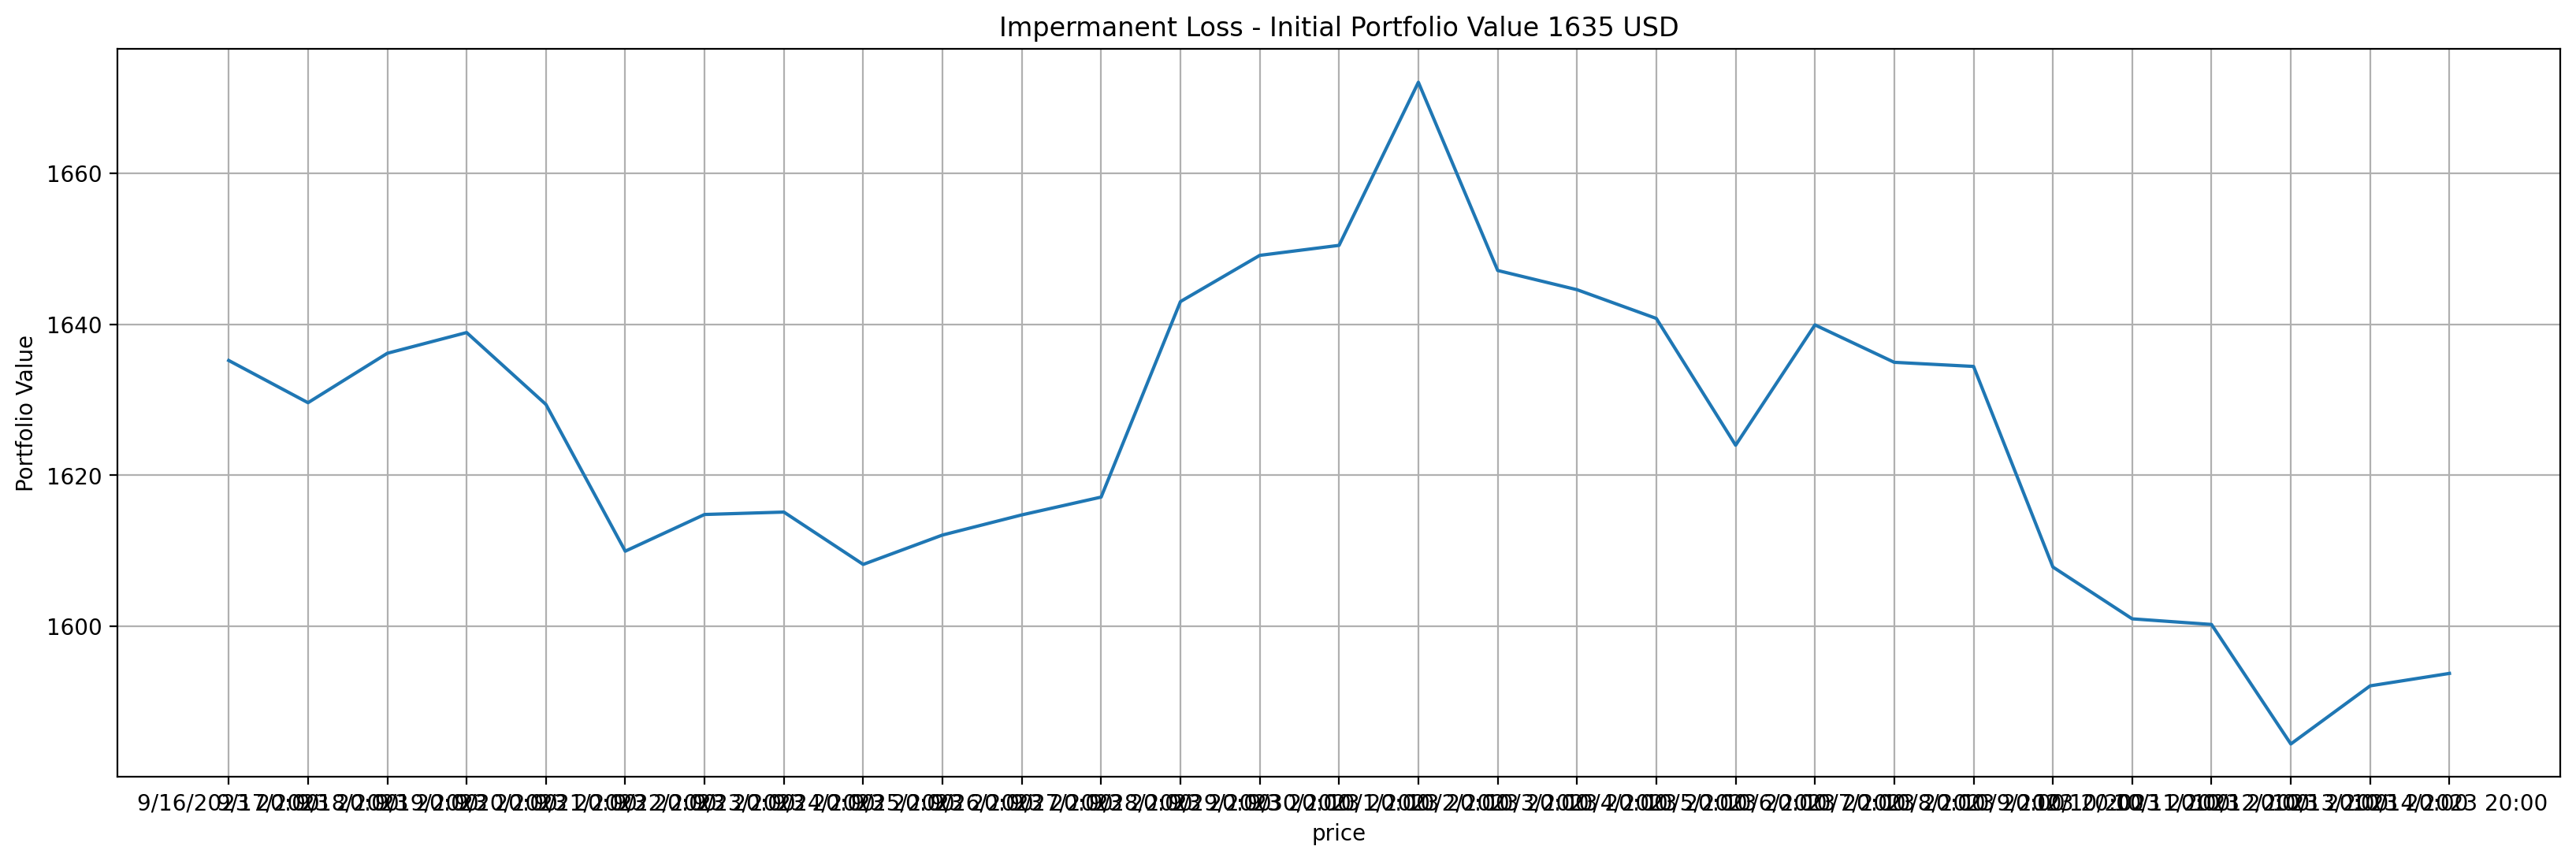

In [22]:
plt.figure(figsize=(20, 6))
plt.plot(df['timestamp'], value_values, linestyle='-')
plt.title('Impermanent Loss - Initial Portfolio Value 1635 USD')
plt.xlabel('price')
plt.ylabel('Portfolio Value')
plt.grid(True)